## Manually colapse the events in images 

Collapse the events in the frames to get the most active pixels and get an 'artificial brightnest' of the image 


In [20]:
# Get system path 
import os
path = os.getcwd()
# Get parent directory
parent = os.path.dirname(path)
#Add parent directory to system path
os.sys.path.insert(0, parent)

from metavision_core.event_io import EventsIterator
import numpy as np
import matplotlib.pyplot as plt

from lib.utils import *
from lib.plot_utils import *   
from lib.event_processing import *

from metavision_core.event_io import EventsIterator
from metavision_sdk_core import PeriodicFrameGenerationAlgorithm
from metavision_sdk_ui import EventLoop, BaseWindow, Window, UIAction, UIKeyEvent

import cv2

In [3]:
#Dynamicaly reload modules in juptyer notebook
%load_ext autoreload 
%autoreload 2

In [4]:
path = "../data/recordings/recording_2024-01-25_17-50-23.raw"
mv_iterator = EventsIterator(input_path=path, delta_t=1000)

height, width = mv_iterator.get_size()  # Camera Geometry
event_frame_gen = PeriodicFrameGenerationAlgorithm(width, height, accumulation_time_us=50000)

frames = []

def on_cd_frame_cb(ts, cd_frame):
    # window.show(cd_frame)
    frames.append(cd_frame)


event_frame_gen.set_output_callback(on_cd_frame_cb)

for evs in mv_iterator:
    event_frame_gen.process_events(evs)

print(len(frames))


278


In [5]:
#Plot one frame as an example 

img = np.array(frames[4])
# img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# print images
cv2.imshow('image',gray)  
cv2.waitKey() # This is necessary to be required so that the image doesn't close immediately.   
cv2.destroyAllWindows() 

qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/ignaciozm/.local/lib/python3.10/site-packages/cv2/qt/plugins"


In [23]:
# Compact the frames

max_buffer = 10
blend = np.array(np.zeros((cv2.cvtColor(np.array(frames[0]), cv2.COLOR_BGR2GRAY).shape)))
copact_frames = []
count = 0
frames_buffer = []


for frame in frames:
    frames_buffer.append(frame)

    if len(frames_buffer) == max_buffer:
        blend = blend_buffer(frames_buffer, mirror=True)
        copact_frames.append(blend.astype(np.uint8))
        frames_buffer = []

print(len(copact_frames))

27


In [24]:
# Whach the compacted frames (OPTIONAL)

for frame in copact_frames:
    dst = cv2.fastNlMeansDenoising(frame)
    cv2.imshow('press q to quit', dst)  
    key = cv2.waitKey() # This is necessary to be required so that the image doesn't close immediately.   
    
    if key == ord('q'):
            cv2.destroyAllWindows()
            break
    
    cv2.destroyAllWindows()

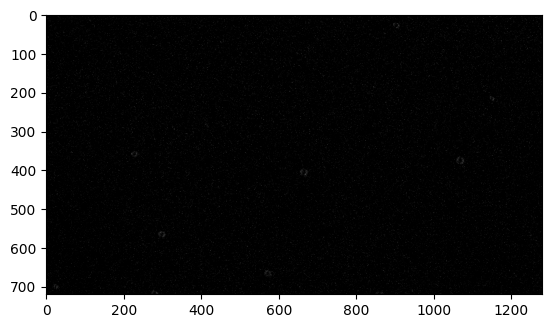

max value:  68
min value:  0


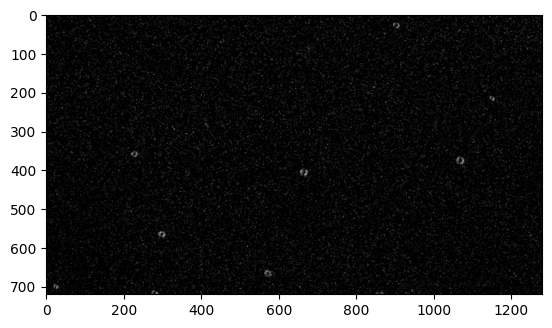

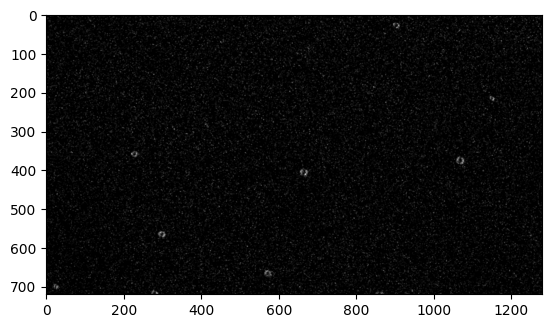

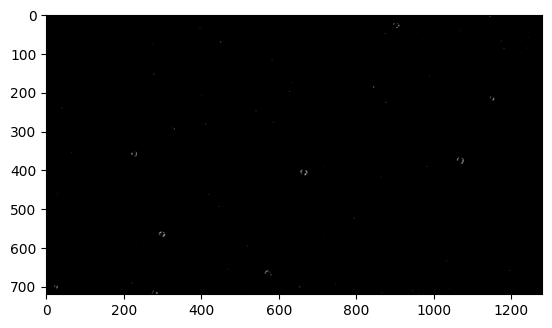

In [45]:
# Check different filters (OPTIONAL)

frame = copact_frames[5]
frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX)
plot_image(np.array(frame))

# plot_image(np.array(cv2.fastNlMeansDenoising(copact_frames[5])))
frame = cv2.blur(frame,(3,3))
print('max value: ', np.max(frame)), print('min value: ', np.min(frame))
plot_image(np.array(frame))

#Transform image to 0 255 range
frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX)
plot_image(np.array(frame))

frame = cv2.threshold(frame, 100, 1, cv2.THRESH_TOZERO)[1]
plot_image(np.array(frame))


In [118]:
from lib.utils import *
from lib.event_processing import *

# Get the clusters of the image

# Treshold filter 
def cv_plot(frame):
    cv2.imshow('image',frame)  
    cv2.waitKey() # This is necessary to be required so that the image doesn't close immediately.   
    cv2.destroyAllWindows()

treshold = 0.3 # Percetange of max value 

filtered_frames = []
clusters_list = []
pixel_range = 20

for frame in copact_frames:

    frame = cv2.blur(frame,(3,3))
    frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX)

    max_val = np.max(frame)
    frame_thr = cv2.threshold(frame, max_val*treshold, 1, cv2.THRESH_TOZERO)[1]
    

    filtered_frames.append(frame_thr)
    # cv_plot(frame_thr)
    clusters =  max_value_cluster(frame_thr, pixel_range, 20)
    clusters = sorted(clusters, key=lambda x: x[1], reverse=True)
    clusters_index = np.array([cluster[0] for cluster in clusters])
    clusters_index = sorted(clusters_index, key=lambda x: x[1], reverse=True)
    clusters_list.append( index_cluster(frame, pixel_range, clusters_index) )

/tmp/ipykernel_4468/436371687.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clusters_index = np.array([cluster[0] for cluster in clusters])


TypeError: 'NoneType' object is not subscriptable

Original clusters:  27 Fitered clusters:  8


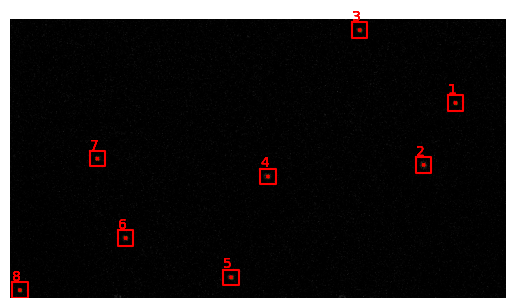

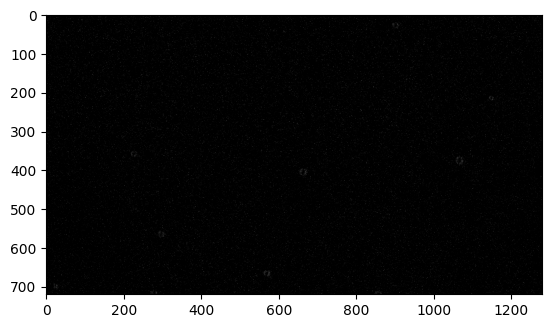

In [111]:
#delete the clusters with a mass lower than a treshold
treshold = 0.5*np.max([cluster_mass[1] for cluster_mass in  clusters_list[12]])

clusters_list_filtered = [cluster for cluster in clusters_list[12] if cluster[1] > treshold ]

print('Original clusters: ', len(clusters_list),'Fitered clusters: ',  len(clusters_list_filtered))


#JUST TO CHECK SOM WITHOUT FALSE STARS
# clusters_list[12].pop(4) # Remove the cluster 4 of the frame 12

plot_cluster(copact_frames[12], clusters_list_filtered, pixel_range)
plot_image(copact_frames[12])
# plot_cluster(treshold_filter(frames[11], treshold ), clusters, 40)

#remove the position 4 of the clusters list


## GET STAR FEATURES AND STAR CENTROID 

Image center:  [360.  640.    1.5]
Order by distance to the center of the image
Cluster 1 [array([406, 665]), 48740]: distance to center: 52.354560450833695
Cluster 2 [array([666, 571]), 44984]: distance to center: 313.68296096536704
Cluster 3 [array([566, 300]), 39136]: distance to center: 397.53741962235455
Cluster 4 [array([362, 228]), 35251]: distance to center: 412.0048543403342
Cluster 5 [array([712, 855]), 22981]: distance to center: 412.46696837443847
Cluster 6 [array([ 28, 902]), 36545]: distance to center: 422.927889834662
Cluster 7 [array([ 376, 1068]), 55065]: distance to center: 428.2989610073786
Cluster 8 [array([712, 280]), 24466]: distance to center: 503.491807281906
Cluster 9 [array([ 217, 1150]), 32909]: distance to center: 529.6687644179143
Cluster 10 [array([700,  27]), 31365]: distance to center: 700.9771750920282


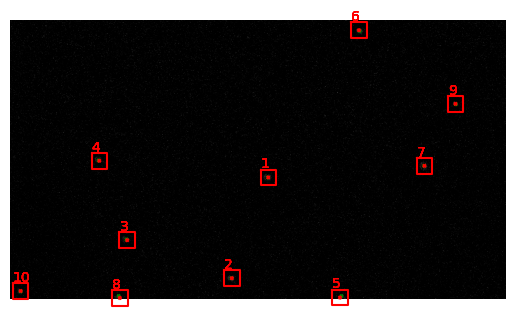

Main cluster:  [array([406, 665]), 48740]
Order by distance to the main cluster
[array([666, 571]), array([712, 855]), array([566, 300]), array([ 376, 1068]), array([362, 228]), array([ 28, 902]), array([712, 280]), array([ 217, 1150]), array([700,  27])]
Main cluster:  [array([666, 571]), 44984]
Order by distance to the main cluster
[array([712, 855]), array([566, 300]), array([712, 280]), array([362, 228]), array([700,  27]), array([ 376, 1068]), array([ 28, 902]), array([ 217, 1150])]


In [30]:
# Pop last value of each cluster (Previous cluster position)
# if len(clusters[0]) == 3:
    # [cluster.pop() for cluster in clusters]


clusters = clusters_list[12]
# Get the clusters that are closest to the center of the image
clusters_sort, clusters_dist= order_by_center_dist([cluster for cluster in clusters ], copact_frames[12].shape)

print('Image center: ', np.array(frames[11].shape)/2)
print('Order by distance to the center of the image')
for i in range(len(clusters_sort)):
    print(f"Cluster {i+1} {clusters_sort[i][:2]}: distance to center: {clusters_dist[i]}")
# Plot the clusters on the image.
    

plot_cluster(copact_frames[12], clusters_sort, pixel_range)

for i in range(2):
    print('Main cluster: ', clusters_sort[i][:2])
    print('Order by distance to the main cluster')
    clusters_sort2 = order_by_main_dist(clusters_sort[i], clusters_sort[i+1:])
    print([cluster[0] for cluster in clusters_sort2])

In [32]:
from lib.event_processing import *
test_get_features()

Features 1 len:  8 , Features 2 len:  10
Main star:  [45.569912  4.089921]
Features 1:  [ 0.023873  0.262952  2.539961  2.570964  4.269875 -0.719941  4.708305
 -0.414241]
Features 2:  [0.26403347 3.61403622 4.33014406 4.72649252 3.41432544 4.35828081
 4.73312725 3.71788356 3.68960223 0.5344842 ]
Test error 1: [ 5.00000041e-08 -3.29999999e-07  3.89999997e-07 -3.89999999e-07
  0.00000000e+00 -3.89999999e-07  2.70000001e-07 -1.09999999e-07]
Test error 2: [-3.24127489e-07 -3.34557360e-09  6.48424301e-08  2.78601703e-07
  2.09994399e-07 -3.51805083e-08  1.86260066e-07 -1.81465176e-07
 -2.97066893e-07  3.81624200e-07]


Features 1 len:  8 , Features 2 len:  10
Main star:  [406 665]
[-1.97579562  0.71432611 -2.32535946 -1.44385064 -1.21587423  2.77371308
  0.22797642 -3.06248321]
[2.10095933 2.73715204 3.02850365 3.07095696 2.18630322 2.19512078
 4.37274511 4.36105506 3.02315985 6.01214536]
True values: 
[1.9952763900000008, -1.9386911100000002, -2.3893697299999985, -1.8715155600000002, 2.950154160000004, 0.9689594399999999, 0.16397194000000326, -3.30202917]
[2.7820228418337023, 3.0350713662058064, 3.105204013286477, 3.3060979169767877, 4.385160675750531, 3.0604286099426465, 2.283060808308521, 6.048042129276693, 2.9267597906479494, 5.099426935430476]
Error: 
[ 0.01948077 -1.224365   -4.71472919 -3.3153662   1.73427993  3.74267252
  0.39194836 -6.36451238]
[ 0.68106351  0.29791933  0.07670036  0.23514096  2.19885745  0.86530783
 -2.0896843   1.68698707 -0.09640006 -0.91271842]


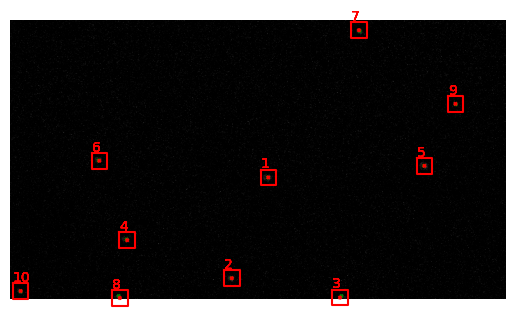

In [34]:
# Get the features of the selected main star 
from lib.event_processing import *

main_star = clusters_sort[0]
stars_sorted_by_main = order_by_main_dist(main_star, clusters_sort)


ref_pixel_to_deg = 0.005319449742301844 /3.5#In degres from sun_calibration with FOV=reference_FOV

reference_FOV = 2 #In degrees
recording_FOV = 10 #In degrees

num_of_neirbours = 4
stars_features_1, stars_features_2 = get_star_features([star[0] for star in 
        stars_sorted_by_main[0:num_of_neirbours+1]], ref_pixel_to_deg, reference_FOV, recording_FOV)
print('Features 1 len: ',len(stars_features_1), ', Features 2 len: ', len(stars_features_2))
print('Main star: ', clusters_sort[0][0])
print(-stars_features_1)
print(stars_features_2)

print('True values: ')
print( [1.9952763900000008, -1.9386911100000002, -2.3893697299999985, -1.8715155600000002, 2.950154160000004, 0.9689594399999999, 0.16397194000000326, -3.30202917])
print( [2.7820228418337023, 3.0350713662058064, 3.105204013286477, 3.3060979169767877, 4.385160675750531, 3.0604286099426465, 2.283060808308521, 6.048042129276693, 2.9267597906479494, 5.099426935430476])

print('Error: ')
print( [1.9952763900000008, -1.9386911100000002, -2.3893697299999985, -1.8715155600000002, 2.950154160000004, 0.9689594399999999, 0.16397194000000326, -3.30202917]-stars_features_1)
print( [2.7820228418337023, 3.0350713662058064, 3.105204013286477, 3.3060979169767877, 4.385160675750531, 3.0604286099426465, 2.283060808308521, 6.048042129276693, 2.9267597906479494, 5.099426935430476]-stars_features_2)

plot_cluster(copact_frames[11], stars_sorted_by_main, pixel_range)


features_vec_1 = []
features_vec_2 = []

for main_star in clusters_sort:
    stars_sorted_by_main = order_by_main_dist(main_star, clusters_sort)
    stars_features_1, stars_features_2 = get_star_features([star[0] for star in stars_sorted_by_main[0:num_of_neirbours+1]])

    features_vec_1.append(stars_features_1)
    features_vec_2.append(stars_features_2)

    recno  TYC1  TYC2  TYC3  BTmag  VTmag      HIP   RA(ICRS)  DE(ICRS)
0    9734    58  1618     1  4.687  2.716  14135.0  45.569912  4.089921
1    9659    58   607     1  5.487  5.591  14143.0  45.593785  4.352873
2   10433    62  1579     1  6.849  5.680  14915.0  48.109873  6.660885
3  134397   641   985     1  4.567  4.681  13954.0  44.928738  8.907399
4  135691   650  1471     1  4.721  3.705  15900.0  51.203480  9.029056

      recno  TYC1  TYC2  TYC3  BTmag  VTmag      HIP   RA(ICRS)  DE(ICRS)
1571   7754    46  1631     1  6.905  5.411  11738.0  37.875347  2.267207


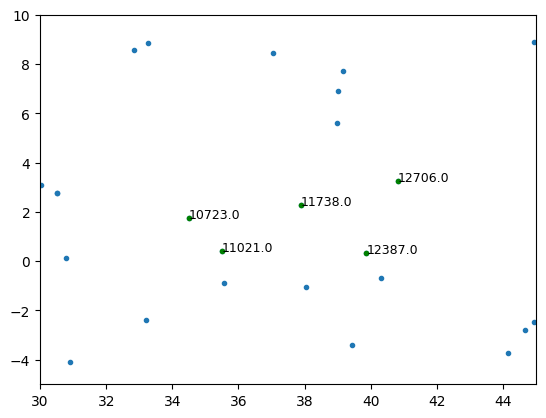

In [16]:
stars_data = get_star_dataset(type ='tycho', path = '../data/catalogs/tycho2_VT_6.csv')
print(stars_data.head())
print()
print(stars_data[stars_data['HIP'] == 11738])

if isinstance(stars_data, pd.DataFrame):
    # stars_data['data_number'] = stars_data.index
    stars_data = stars_data[['HIP','RA(ICRS)', 'DE(ICRS)']].values
 
stars_subset = [12706, 11738, 10723, 11687, 11021, 12387]
stars_subdata = stars_data[np.where(np.isin(stars_data[:,0], stars_subset))]
    
plt.figure()
plt.plot([x[1] for x in stars_data],stars_data[:,2],'.')

plt.plot([x[1] for x in stars_subdata],stars_subdata[:,2],'.g')
#Plot the identification names of the sub set of stars
for i in range(len(stars_subdata)):
    plt.text(stars_subdata[i,1], stars_subdata[i,2], stars_subdata[i,0], fontsize=9)

#change the limits of the axis
plt.xlim([30, 45])
plt.ylim([-5, 10])

plt.show()  

In [17]:
import minisom 
import pickle

mesh_size = 35
catalog_filter = 6

name = 'n'+ str(mesh_size) +'_tycho' + str(catalog_filter)


#Load som from previusly trained model
with open('../data/SOM_parameters/som1_'+ name + '.p', 'rb') as infile:
    som1 = pickle.load(infile)

with open('../data/SOM_parameters/som2_'+ name + '.p', 'rb') as infile:
    som2 = pickle.load(infile)

#Load normalization parameters
with open('../data/SOM_parameters/normalization_parameters_'+ name + '.p', 'rb') as infile:
    norm_param = pickle.load(infile)

#Load dictionary with the star features
with open('../data/SOM_parameters/star_dict_'+ name + '.p', 'rb') as infile:
    star_dict_1, star_dict_2 = pickle.load(infile)


In [41]:
#Get the image postion
from lib.event_processing import *


features_1 = stars_features_1
features_2 = stars_features_2

predicted_star_ids_1 = predict_star_id(features_1, norm_param[0:2], star_dict_1, som1)
predicted_star_ids_2 = predict_star_id(features_2, norm_param[2:4], star_dict_2, som2)

hip_ids_predicted_1 = [stars_data[x][0].astype(int) for x in predicted_star_ids_1]
hip_ids_predicted_2 = [stars_data[x][0].astype(int) for x in predicted_star_ids_2]

print('Predicted star ids 1: ', hip_ids_predicted_1)
print('Predicted star ids 2: ', hip_ids_predicted_2)

if len(list(set(predicted_star_ids_1).intersection(predicted_star_ids_2))) < 2 and len(
    list(set(predicted_star_ids_1).intersection(predicted_star_ids_2))) > 0:

    star_guess = list(set(predicted_star_ids_1).intersection(predicted_star_ids_2))[0]
    print('Predicted star id: ', star_guess)
    print(stars_data[stars_data.index == star_guess])
else:
    star_guess = None
    print('Predicted star id: ', star_guess)






# print(stars_data[stars_data[star_guess]])

Predicted star ids 1:  [92824]
Predicted star ids 2:  [47193]
Predicted star id:  None


In [ ]:
star_postion = np.array([60,80]) #EXAMPLE -> GET FROM SOM

img_center = np.array(copact_frames[11].shape)/2


print('Main star: ', main_star[0])
distance_to_center = main_star[0] - img_center
print('Pixel distance to center: ', distance_to_center)
print('Distance to center: ', distance_to_center*pixel_to_deg)
print('Camera position: ', star_postion + distance_to_center*pixel_to_deg)